# Twitter Emotion Analysis using Machine Learning

## 1. Prerequisites

Import required libraries.

In [192]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
import operator
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer


## 2. Read Data

Read tweet text data from 3 files train/validation/test into a list or dataframe. Also read the given labels for 11 emotions.

In [220]:
#Read tweet data from convert to .csv file    
Val_df = pd.read_csv('2018-E-c-En-dev.txt',delimiter="\t",header=None,names=["Tweet ID","Tweet Text","Joy","Sadness","anger","fear","Trust","Disgust","Surprise","Anticipation","optimism","pessimism","love"])
Val_df.to_csv('2018-E-c-En-dev.csv',index=None)

test_df = pd.read_csv('2018-E-c-En-test-gold.txt',delimiter="\t",header=None,names=["Tweet ID","Tweet Text","Joy","Sadness","anger","fear","Trust","Disgust","Surprise","Anticipation","optimism","pessimism","love"])
test_df.to_csv('2018-E-c-En-test-gold.csv',index=None)

train_df = pd.read_csv('2018-E-c-En-train.txt',delimiter="\t",header=None,names=["Tweet ID","Tweet Text","Joy","Sadness","anger","fear","Trust","Disgust","Surprise","Anticipation","optimism","pessimism","love"])
train_df.to_csv('2018-E-c-En-train.csv',index=None)

train_df = pd.read_csv("2018-E-c-En-train.csv")
test_df = pd.read_csv("2018-E-c-En-test-gold.csv")
val_df = pd.read_csv("2018-E-c-En-dev.csv")

#print('Train data')
print(train_df.head())
print(train_df.shape)

#print('Test Data')
print(test_df.head())
print(test_df.shape)

#print('Validation Data')
print(val_df.head())
print(val_df.shape)






        Tweet ID                                         Tweet Text  Joy  \
0  2017-En-21441  “Worry is a down payment on a problem you may ...    0   
1  2017-En-31535  Whatever you decide to do make sure it makes y...    0   
2  2017-En-21068  @Max_Kellerman  it also helps that the majorit...    1   
3  2017-En-31436  Accept the challenges so that you can literall...    0   
4  2017-En-22195  My roommate: it's okay that we can't spell bec...    1   

   Sadness  anger  fear  Trust  Disgust  Surprise  Anticipation  optimism  \
0        1      0     0      0        0         1             0         0   
1        0      0     0      1        1         1             0         0   
2        0      1     0      1        0         1             0         0   
3        0      0     0      1        0         1             0         0   
4        0      1     0      0        0         0             0         0   

   pessimism  love  
0          0     1  
1          0     0  
2          0     

## 3. Exploratory data analysis

Check data attributes such as length of tweets, distribution of each of 11 emotion labels etc.

In [194]:
#Length of Tweets
print("Length of tweets for train_df") 
print(train_df['Tweet Text'].str.len())
print("\n\n")

print("Length of tweets for val_df")
print(val_df['Tweet Text'].str.len())
print("\n\n")

print("Length of tweets for test_df") 
print(test_df['Tweet Text'].str.len())





Length of tweets for train_df
0       104
1        56
2       128
3       109
4        98
       ... 
6833    116
6834    140
6835    140
6836     65
6837     48
Name: Tweet Text, Length: 6838, dtype: int64



Length of tweets for val_df
0       92
1       58
2      135
3      143
4       73
      ... 
881     93
882     82
883    138
884    112
885    136
Name: Tweet Text, Length: 886, dtype: int64



Length of tweets for test_df
0       100
1       139
2        33
3        38
4       144
       ... 
3254    110
3255    131
3256     43
3257    106
3258     83
Name: Tweet Text, Length: 3259, dtype: int64


<AxesSubplot:>

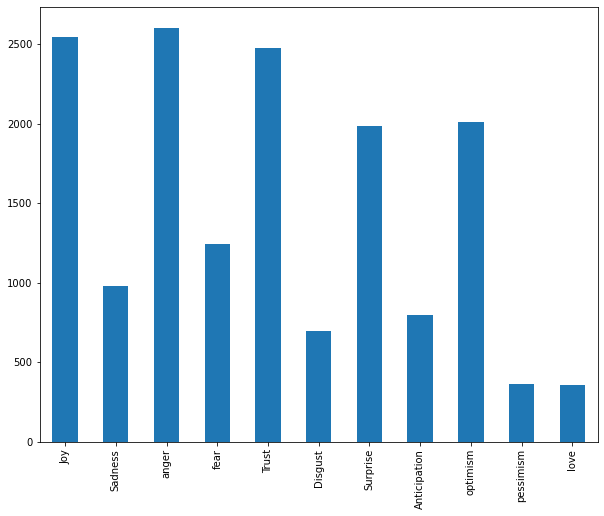

In [228]:
#Distribution of each of 11 emotion labels(Train):
Emotion_labels_train = train_df[["Joy","Sadness","anger","fear","Trust","Disgust","Surprise","Anticipation","optimism","pessimism","love"]]
Emotion_labels_train.head()

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 8
plt.rcParams["figure.figsize"] = fig_size

Emotion_labels_train.sum(axis=0).plot.bar()

<AxesSubplot:>

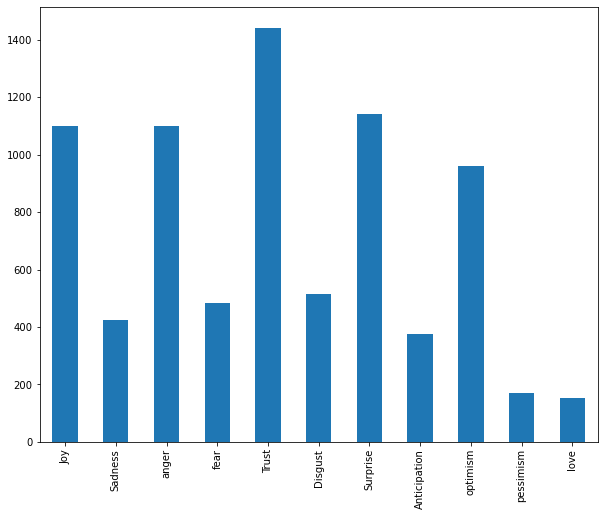

In [225]:
#Distribution of each of 11 emotion labels(test):
Emotion_labels_test = test_df[["Joy","Sadness","anger","fear","Trust","Disgust","Surprise","Anticipation","optimism","pessimism","love"]]
Emotion_labels_test.head()

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 8
plt.rcParams["figure.figsize"] = fig_size

Emotion_labels_test.sum(axis=0).plot.bar()

   Joy  Sadness  anger  fear  Trust  Disgust  Surprise  Anticipation  \
0    1        0      1     0      0        0         0             0   
1    0        0      0     0      1        1         1             0   
2    1        0      1     0      0        0         0             0   
3    0        0      0     0      1        0         1             0   
4    0        0      0     1      0        0         0             0   

   optimism  pessimism  love  
0         0          0     0  
1         0          0     0  
2         0          0     0  
3         0          0     0  
4         0          0     0  


<AxesSubplot:>

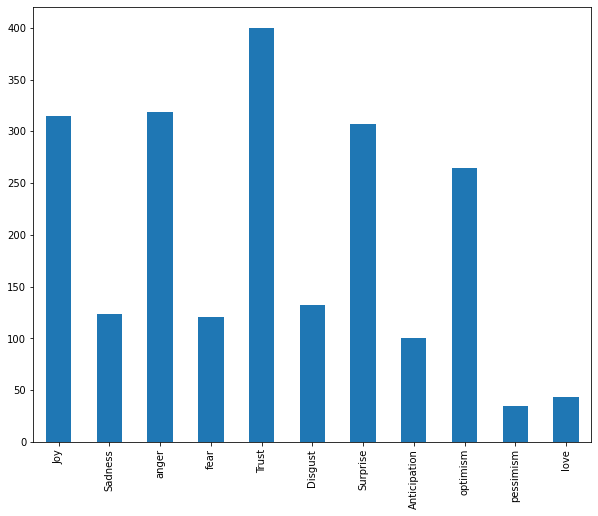

In [197]:
#Distribution of each of 11 emotion labels(Val):
Emotion_labels_val = val_df[["Joy","Sadness","anger","fear","Trust","Disgust","Surprise","Anticipation","optimism","pessimism","love"]]
print(Emotion_labels_val.head())

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 8
plt.rcParams["figure.figsize"] = fig_size

Emotion_labels_val.sum(axis=0).plot.bar()

## 4. Data Preprocessing

This is the main part of the model. You need to perform the pre-processing as described in chapter 4 and 5 of the report. You can leave out complicated part such as POS tagging. Just see whatever steps you can include in reasonable time. The out of this step is each tweet converted into a list/tensor of numbers.

In [198]:
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [199]:
from bs4 import BeautifulSoup


def preprocess_reviews(tweets):
    tweets = re.sub("http\S+", "",tweets.lower())
    tweets = BeautifulSoup(tweets, 'lxml').get_text()
    tweets = re.sub("[^A-Za-z]+"," ", tweets)
    tweets = re.sub("\S*\d\S*", "" , tweets) 
    tweets = decontracted(tweets)
    
    
    return tweets




#target_train = reviews_train['Label']
#target_test = reviews_test['Label']

In [200]:
#tweets_train_clean = preprocess_reviews(train_df['Tweet Text'])
train_df['Tweet Text'] = train_df['Tweet Text'].apply(preprocess_reviews)

In [201]:
#tweets_test_clean = preprocess_reviews(test_df['Tweet Text'])
test_df['Tweet Text'] = test_df['Tweet Text'].apply(preprocess_reviews)

In [202]:
#tweets_val_clean = preprocess_reviews(val_df['Tweet Text'])
val_df['Tweet Text'] = val_df['Tweet Text'].apply(preprocess_reviews)

In [166]:
from nltk.corpus import stopwords
nltk.download('stopwords')
print(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\SHUBHA\AppData\Roaming\nltk_data...


['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

[nltk_data]   Unzipping corpora\stopwords.zip.


In [203]:
stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y'])

In [204]:
#Removing Stop words

def remove_stop_words(tweet):
    rstop_words = ""
    for word in tweet.split():
        if not word in stopwords:
            stop = word
            rstop_words += word
            rstop_words += " "
            #rstop_words = rstop_words.strip()
        
    return rstop_words

train_df['Tweet Text'] = train_df['Tweet Text'].apply(remove_stop_words)
test_df['Tweet Text'] = test_df['Tweet Text'].apply(remove_stop_words)
val_df['Tweet Text'] = val_df['Tweet Text'].apply(remove_stop_words)

train_df.head()



,Tweet ID,Tweet Text,Joy,Sadness,anger,fear,Trust,Disgust,Surprise,Anticipation,optimism,pessimism,love
0,2017-En-21441,worry payment problem may never joyce meyer mo...,0,1,0,0,0,0,1,0,0,0,1
1,2017-En-31535,whatever decide make sure makes happy,0,0,0,0,1,1,1,0,0,0,0
2,2017-En-21068,max kellerman also helps majority nfl coaching...,1,0,1,0,1,0,1,0,0,0,0
3,2017-En-31436,accept challenges literally even feel exhilara...,0,0,0,0,1,0,1,0,0,0,0
4,2017-En-22195,roommate okay spell autocorrect terrible first...,1,0,1,0,0,0,0,0,0,0,0


In [205]:
#Stemming
from nltk.stem.snowball import SnowballStemmer

stemmer = SnowballStemmer("english")
def stemming(sentence):
    stemSentence = ""
    for word in sentence.split():
        stem = stemmer.stem(word)
        stemSentence += stem
        stemSentence += " "
    #stemSentence = stemSentence.strip()
    return stemSentence



train_df['Tweet Text'] = train_df['Tweet Text'].apply(stemming)
test_df['Tweet Text'] = test_df['Tweet Text'].apply(stemming)
val_df['Tweet Text'] = val_df['Tweet Text'].apply(stemming)

train_df.head()



,Tweet ID,Tweet Text,Joy,Sadness,anger,fear,Trust,Disgust,Surprise,Anticipation,optimism,pessimism,love
0,2017-En-21441,worri payment problem may never joyc meyer mot...,0,1,0,0,0,0,1,0,0,0,1
1,2017-En-31535,whatev decid make sure make happi,0,0,0,0,1,1,1,0,0,0,0
2,2017-En-21068,max kellerman also help major nfl coach inept ...,1,0,1,0,1,0,1,0,0,0,0
3,2017-En-31436,accept challeng liter even feel exhilar victor...,0,0,0,0,1,0,1,0,0,0,0
4,2017-En-22195,roommat okay spell autocorrect terribl firstwo...,1,0,1,0,0,0,0,0,0,0,0


In [206]:
Lemmatization
def get_lemmatized_text(corpus):
    
   from nltk.stem import WordNetLemmatizer
  #  lemmatizer = WordNetLemmatizer()
   # return [' '.join([lemmatizer.lemmatize(word) for word in tweet.split()]) for tweet in corpus]

#tweets_train_clean = get_lemmatized_text(tweets_train_clean)
#tweets_test_clean = get_lemmatized_text(tweets_test_clean)
#tweets_val_clean = get_lemmatized_text(tweets_val_clean)



In [207]:
categories = ["Joy","Sadness","anger","fear","Trust","Disgust","Surprise","Anticipation","optimism","pessimism","love"]

In [208]:
train_text = train_df['Tweet Text']
test_text = test_df['Tweet Text']
val_text = val_df['Tweet Text']

TFIDF

In [209]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(strip_accents='unicode', analyzer='word', ngram_range=(1,2), norm='l2')
vectorizer.fit(train_text)
vectorizer.fit(test_text)
vectorizer.fit(val_text)


TfidfVectorizer(ngram_range=(1, 2), strip_accents='unicode')

In [210]:
val_df.head()

,Tweet ID,Tweet Text,Joy,Sadness,anger,fear,Trust,Disgust,Surprise,Anticipation,optimism,pessimism,love
0,2018-En-00866,ranaayyub rajnathsingh oh hidden reveng anger ...,1,0,1,0,0,0,0,0,0,0,0
1,2018-En-02590,make sure smile bro,0,0,0,0,1,1,1,0,0,0,0
2,2018-En-03361,not teamchristin bc tana done provok tweet sha...,1,0,1,0,0,0,0,0,0,0,0
3,2018-En-03230,great start beginn jump auto trade profit fx e...,0,0,0,0,1,0,1,0,0,0,0
4,2018-En-01143,best friend drive first time car terrifi,0,0,0,1,0,0,0,0,0,0,0


In [211]:
x_train = vectorizer.transform(train_text)
y_train = train_df.drop(labels = ['Tweet ID','Tweet Text'], axis=1)

x_test = vectorizer.transform(test_text)
y_test = test_df.drop(labels = ['Tweet ID','Tweet Text'], axis=1)

x_val = vectorizer.transform(val_text)
y_val = val_df.drop(labels = ['Tweet ID','Tweet Text'], axis=1)




## 5. Naive Bayes Model

Naive bayes model from Scikit learn can be used directly on the preprocessed data. (https://scikit-learn.org/stable/modules/naive_bayes.html)

## 6. Naive Bayes model training and evaluation

In [219]:
# Define a pipeline combining a text feature extractor with multi lable classifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score,roc_curve,classification_report,confusion_matrix,plot_confusion_matrix


clf = MultinomialNB()

# predict the outcome for testing data
                       
                        
for category in categories:
    print('... Processing {}'.format(category))
    # train the model using X_dtm & y
    clf.fit(x_train, train_df[category])
    # compute the testing accuracy
    prediction = clf.predict(x_val)
    print('Val accuracy is {}'.format(accuracy_score(val_df[category], prediction)))
    #print(classification_report(val_df[category],prediction))
    
    prediction = clf.predict(x_test)
    print('Test accuracy is {}'.format(accuracy_score(test_df[category], prediction)))
    #print(classification_report(test_df[category],prediction))

    
  

... Processing Joy
Val accuracy is 0.7720090293453724
Test accuracy is 0.7621969929426204
              precision    recall  f1-score   support

           0       0.75      0.97      0.84      2158
           1       0.87      0.35      0.50      1101

    accuracy                           0.76      3259
   macro avg       0.81      0.66      0.67      3259
weighted avg       0.79      0.76      0.73      3259

... Processing Sadness
Val accuracy is 0.8487584650112867
Test accuracy is 0.8695918993556305
              precision    recall  f1-score   support

           0       0.87      1.00      0.93      2834
           1       0.00      0.00      0.00       425

    accuracy                           0.87      3259
   macro avg       0.43      0.50      0.47      3259
weighted avg       0.76      0.87      0.81      3259

... Processing anger
Val accuracy is 0.7460496613995485
Test accuracy is 0.733046946916232
              precision    recall  f1-score   support

           0    

C:\Users\SHUBHA\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\SHUBHA\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\SHUBHA\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\SHUBHA\anaconda3\lib\site-packages\sklearn\

## 7. Support Vector Machine (SVM)


Scikit learn has a SVM model, which can be directly used (https://scikit-learn.org/stable/modules/svm.html).

## 8. SVM training and evaluation

In [213]:
#Fitting SVM to training set
from sklearn.svm import LinearSVC

svm = LinearSVC()

# predict the outcome for testing data
                       
    
for category in categories:
    print('... Processing {}'.format(category))
    # train the model using X_train & y
    svm.fit(x_train, train_df[category])
    # compute the testing accuracy
    prediction = svm.predict(x_val)
    print('Val accuracy is {}'.format(accuracy_score(val_df[category], prediction)))
    #print(classification_report(val_df[category],prediction))
    
    prediction = svm.predict(x_test)
    print('Test accuracy is {}'.format(accuracy_score(test_df[category], prediction)))
    
    #print(classification_report(test_df[category],prediction))


... Processing Joy
Val accuracy is 0.7776523702031602
Test accuracy is 0.7953359926357778
... Processing Sadness
Val accuracy is 0.8611738148984198
Test accuracy is 0.8493402884320344
... Processing anger
Val accuracy is 0.7392776523702032
Test accuracy is 0.7551396133783369
... Processing fear
Val accuracy is 0.8984198645598194
Test accuracy is 0.9091745934335685
... Processing Trust
Val accuracy is 0.755079006772009
Test accuracy is 0.8063823258668303
... Processing Disgust
Val accuracy is 0.8679458239277652
Test accuracy is 0.8683645289966248
... Processing Surprise
Val accuracy is 0.7370203160270881
Test accuracy is 0.7404111690702669
... Processing Anticipation
Val accuracy is 0.8848758465011287
Test accuracy is 0.8815587603559374
... Processing optimism
Val accuracy is 0.7618510158013544
Test accuracy is 0.7821417612764652
... Processing pessimism
Val accuracy is 0.9593679458239278
Test accuracy is 0.9441546486652347
... Processing love
Val accuracy is 0.9514672686230248
Test acc

In [214]:
#Fitting Logistic Regression to training set
from sklearn.linear_model import LogisticRegression


lr = LogisticRegression()


# predict the outcome for testing data
                       
    
for category in categories:
    print('... Processing {}'.format(category))
    # train the model using X_train & y
    lr.fit(x_train, train_df[category])
    # compute the testing accuracy
    prediction = lr.predict(x_val)
    print('Val accuracy is {}'.format(accuracy_score(val_df[category], prediction)))
    #print(classification_report(val_df[category],prediction))
    
    prediction = lr.predict(x_test)
    print('Test accuracy is {}'.format(accuracy_score(test_df[category], prediction)))
    #print(classification_report(test_df[category],prediction))


... Processing Joy
Val accuracy is 0.7415349887133182
Test accuracy is 0.7980975759435409
... Processing Sadness
Val accuracy is 0.8600451467268623
Test accuracy is 0.869898741945382
... Processing anger
Val accuracy is 0.7279909706546276
Test accuracy is 0.7643448910708807
... Processing fear
Val accuracy is 0.8803611738148984
Test accuracy is 0.8996624731512733
... Processing Trust
Val accuracy is 0.7099322799097065
Test accuracy is 0.7962565204050323
... Processing Disgust
Val accuracy is 0.8544018058690744
Test accuracy is 0.8695918993556305
... Processing Surprise
Val accuracy is 0.7144469525959368
Test accuracy is 0.74317275237803
... Processing Anticipation
Val accuracy is 0.8860045146726863
Test accuracy is 0.8852408714329549
... Processing optimism
Val accuracy is 0.7528216704288939
Test accuracy is 0.7845965019944768
... Processing pessimism
Val accuracy is 0.9604966139954854
Test accuracy is 0.949064130101258
... Processing love
Val accuracy is 0.9514672686230248
Test accura

In [215]:
# The three classifiers produced similar results